# Group 13 - Yelp Review Analysis for Module 3 
Group members:
- Jonquil Liao
- Yuhan Zhou
- Yike Wang

In [1]:
# import initial modules
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

# Preparation and trial

In [2]:
# read in reviews from previous notebook
data = pd.read_csv('review_steakhouse.csv')

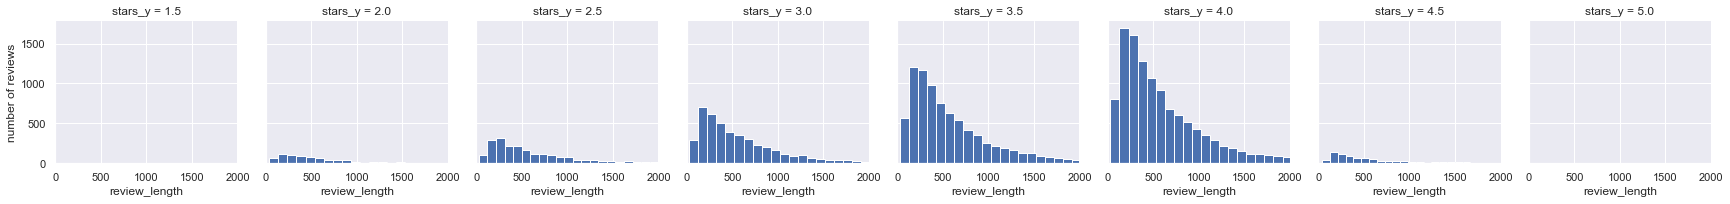

In [5]:
import seaborn as sns
sns.set()
data['review_length'] = data.text.map(len)
ax = sns.FacetGrid(data=data, col='stars_y',xlim=(0, 2000)).map(plt.hist, 'review_length', bins=50)
ax.axes[0][0].set(ylabel='number of reviews');

In [6]:
data['review_length'] = data.text.map(len)

In [7]:
import numpy as np
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re, string
import sys
import time
import collections
from array import array

In [123]:
badreviews = data[(data.stars_x <= 3 )]
goodreviews = data[(data.stars_x > 3)]
badreviews = badreviews.text
goodreviews = goodreviews.text
print('Postive Reviews:  {:,}'.format(len(goodreviews)))
print('Negative Reviews:  {:,}'.format(len(badreviews)))

Postive Reviews:  17,270
Negative Reviews:  11,139


In [124]:
badreviews = ["".join([char for char in a if char not in string.punctuation]) for a in badreviews]
goodreviews = ["".join([char for char in a if char not in string.punctuation]) for a in goodreviews]

In [125]:
# additional stopwords
from sklearn.feature_extraction import text 
extra_words = ['ve', 'like', 'got', 'just', 'us','great',
               'good','best','nice','always','back','ever',
               'ive','go','well','not','bad','terrible',
               'don', 'really', 'said', 'told', 'ok','dont',
               'came', 'went', 'did', 'didn','one','would']
stop_words = text.ENGLISH_STOP_WORDS.union(extra_words)

In [126]:
text1=badreviews
text1 = [a.lower() for a in text1]
words1 = [nltk.word_tokenize(a) for a in text1]
filtered_words1 = [[word for word in a if word not in stop_words] for a in words1]
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()

In [127]:
text2=goodreviews
text2 = [a.lower() for a in text2]
words2 = [nltk.word_tokenize(a) for a in text2]
filtered_words2 = [[word for word in a if word not in stop_words] for a in words2]

In [128]:
lemmatized_words1 = [[lmtzr.lemmatize(x) for x in a] for a in filtered_words1]
lemmatized_words2 = [[lmtzr.lemmatize(x) for x in a] for a in filtered_words2]

In [129]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
lemmatized_words1=[ ' '.join(map(str, sent)) for sent in lemmatized_words1]
lemmatized_words2=[ ' '.join(map(str, sent)) for sent in lemmatized_words2]

In [130]:
tfidf_model1 = TfidfVectorizer(stop_words=stop_words,
                        ngram_range=(1,1))
tfidf_model2 = TfidfVectorizer(stop_words=stop_words, 
                        ngram_range=(1,1))
result1=tfidf_model1.fit_transform(lemmatized_words1)
result2=tfidf_model2.fit_transform(lemmatized_words2)

In [131]:
bad_df = pd.DataFrame(result1.todense(), columns=[tfidf_model1.get_feature_names()])
good_df = pd.DataFrame(result2.todense(), columns=[tfidf_model2.get_feature_names()])
col_means_bad = {}
for col in bad_df:
    col_means_bad[col] = bad_df[col].mean()

col_means_good = {}
for col in good_df:
    col_means_good[col] = good_df[col].mean()
    
top_words = 8

print('Top words in good reviews:')
print(sorted(col_means_good, key=col_means_good.get, reverse=True)[:top_words])

print('Top words in bad reviews:')
print(sorted(col_means_bad, key=col_means_bad.get, reverse=True)[:top_words])

Top words in good reviews:
[('food',), ('service',), ('place',), ('steak',), ('time',), ('restaurant',), ('delicious',), ('bar',)]
Top words in bad reviews:
[('food',), ('steak',), ('service',), ('place',), ('time',), ('table',), ('restaurant',), ('ordered',)]


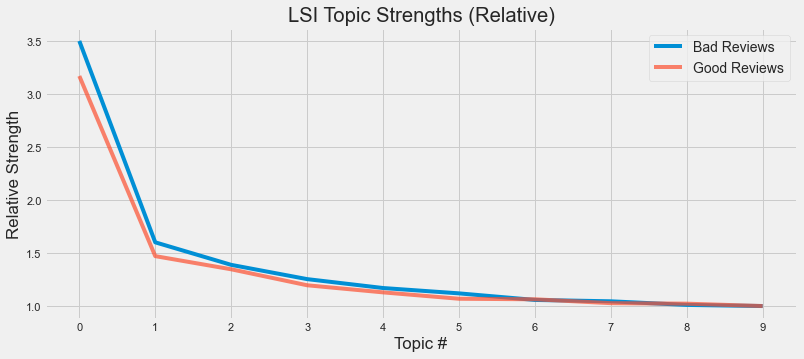

In [132]:
'This part credited to Ankur Vishwakarma, Oakland, CA. https://github.com/Vishwacorp/'
from gensim import corpora, models, similarities, matutils
corpus1 = matutils.Sparse2Corpus(result1.transpose())
corpus2 = matutils.Sparse2Corpus(result2.transpose())
word_bad = dict((v,k) for k,v in tfidf_model1.vocabulary_.items())
word_good = dict((v,k) for k,v in tfidf_model2.vocabulary_.items())
word_bad2 = corpora.Dictionary.from_corpus(corpus1, id2word=word_bad)
word_good2 = corpora.Dictionary.from_corpus(corpus2, id2word=word_good)
lsi_bad = models.LsiModel(corpus1, id2word=word_bad2, num_topics=10)
lsi_good = models.LsiModel(corpus2, id2word=word_good2, num_topics=10)

singular_values_bad = lsi_bad.projection.s.tolist()
singular_values_bad_rel = [sv/singular_values_bad[-1] for sv in singular_values_bad]
singular_values_good = lsi_good.projection.s.tolist()
singular_values_good_rel = [sv/singular_values_good[-1] for sv in singular_values_good]
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,5))
plt.plot(range(len(singular_values_bad)), singular_values_bad_rel, label='Bad Reviews', alpha=1.0)
plt.plot(range(len(singular_values_good)), singular_values_good_rel, label='Good Reviews', alpha=0.7)
plt.xticks(range(len(singular_values_bad)), range(len(singular_values_bad)))
plt.xlabel('Topic #')
plt.ylabel('Relative Strength')
plt.title('LSI Topic Strengths (Relative)')
plt.legend(loc=0, fontsize='medium');

In [133]:
import pprint
from pprint import pprint

In [134]:
no_top_words = 8

print('Top %d words in POSITIVE reviews:' %no_top_words, end='')
print(sorted(col_means_good, key=col_means_good.get, reverse=True)[:no_top_words])

print('Top %d words in NEGATIVE reviews:' %no_top_words, end='')
print(sorted(col_means_bad, key=col_means_bad.get, reverse=True)[:no_top_words])

Top 8 words in POSITIVE reviews:[('food',), ('service',), ('place',), ('steak',), ('time',), ('restaurant',), ('delicious',), ('bar',)]
Top 8 words in NEGATIVE reviews:[('food',), ('steak',), ('service',), ('place',), ('time',), ('table',), ('restaurant',), ('ordered',)]


### Trial with NMF <a name='s4'></a>

In [135]:
%%time
# negative values in LSA topics are annoying
# let's see if we can fix that with NMF
from sklearn.decomposition import NMF

# change num_topics
num_topics = 4

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(result2)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(result1)
H_neg = nmf_neg.components_

Wall time: 1.61 s


In [136]:
def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

no_topics = num_topics
no_top_words = 6

print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_model2.get_feature_names(), no_topics, no_top_words)

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_model1.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   0.842*salad, 0.798*meat, 0.723*ordered, 0.637*bar, 0.637*delicious, 0.635*dinner
Topic 1:   1.420*cheese, 1.272*curd, 1.161*burger, 0.991*old, 0.896*beer, 0.840*fashioned
Topic 2:   1.705*food, 1.209*service, 0.801*place, 0.716*excellent, 0.684*atmosphere, 0.661*amazing
Topic 3:   2.761*steak, 0.756*cooked, 0.444*perfectly, 0.386*house, 0.384*steakhouse, 0.352*service

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   0.937*salad, 0.809*cheese, 0.745*burger, 0.686*chicken, 0.615*ordered, 0.568*fry
Topic 1:   2.193*steak, 0.774*medium, 0.582*rare, 0.480*cooked, 0.447*ordered, 0.318*filet
Topic 2:   1.091*table, 1.078*minute, 0.688*drink, 0.673*order, 0.637*time, 0.563*server
Topic 3:   1.460*food, 1.029*service, 0.959*place, 0.485*price, 0.471*time, 0.416*restaurant


As expected, these topics are far more interpretable.  
* First two topics for positive reviews seem to be (1) salad and sides and (2) drinks and meals other than steak.
* First two topics for negative reviews seem to be (1) slow service and (2) temperature of steak (seems like thai food in this subset of data).

In [137]:
np.random.seed(3)
num_reviews = 18000
random_pos = np.random.choice(goodreviews, size=num_reviews)

In [138]:
np.random.seed(30)
num_reviews = 5000
random_neg = np.random.choice(badreviews, size=num_reviews)

### Review Similarity in NMF space <a name='s5'></a>

In [139]:
# look at a random positive review
review_num = np.random.randint(0, high=len(random_pos))
print(review_num)
print(random_pos[review_num])

11657
I like this Texas Roadhouse location Like it so much we drive past the Washington location to get here 
They dont take reservations but the call ahead seating is so nice You just call when youre on your way and they put your name down on the wait list 
For a chain restaurant their steaks are very good Actually pretty much everything on the menu is good Prices are affordable and the staff is friendly


In [140]:
# compute cosine similarities of this review with all other reviews in the new space
import sklearn.metrics.pairwise as smp

cosines = {}
for ind, review in enumerate(W_pos):
    similarity = smp.cosine_similarity(W_pos[review_num].reshape(1,-1), review.reshape(1,-1))
    cosines[ind] = similarity[0][0]

In [141]:
# get top 3 matching reviews
for n in sorted(cosines, key=cosines.get, reverse=True)[1:4]:
    print('-'*50)
    print('>> Similarity {:.3f}'.format(cosines[n]))
    print(random_pos[n])
print('-'*50)

--------------------------------------------------
>> Similarity 1.000
My husband and I went to The Corkscrew Saloon for Valentines Day We had reservations and were seated right away Our server Brandon was fabulous The food was phenomenal I had the salmon My husband had the flat iron steak We both had dessert Definitely a 1010 Best dinner weve had out in quite some time Thanks Ryan
--------------------------------------------------
>> Similarity 1.000
I Love Cleveland Chop

This place always wins for me I love the warm cornbread with a little spicy kick the house cocktails and varying Mules crispy fries and dont even get me started on the steak salad Okay so this salad Im always so full from apps cornbread and good drinks that this salad is perfect every time I get to taste the delicious savory steak and also get the fresh flavors from the salad veggies and big bites of blue cheese I get it every time I come here leaving happy and taking plenty home for lunch the next day 

Did you kno

NMF seems to be working well and making good topics for us. But just to give it a shot, let's use CountVectorizer (instead of TFIDF) and try topic modeling through LDA. While slower, its use of a dirichlet prior can often give good results.

### Trial with Count Vectorizer <a name='s6'></a>

In [142]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a vectorizer object to generate term document counts
cv_pos = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

cv_neg = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 5000
cv_random_neg = np.random.choice(badreviews, size=num_reviews)
cv_random_pos = np.random.choice(goodreviews, size=num_reviews)

# Get the cv vectors
cv_neg_vectors = cv_neg.fit_transform(cv_random_neg).transpose()
cv_pos_vectors = cv_pos.fit_transform(cv_random_pos).transpose()

In [143]:
# Convert sparse matrix of counts to a gensim corpus
corpus_neg = matutils.Sparse2Corpus(cv_neg_vectors)
corpus_pos = matutils.Sparse2Corpus(cv_pos_vectors)

# save a mapping (dict) of row id to word (token) for later use by gensim 
id2word_cv_pos = dict((v, k) for k, v in cv_pos.vocabulary_.items())
id2word_cv_neg = dict((v, k) for k, v in cv_neg.vocabulary_.items())

### LDA(Count Vectorizer)<a name='s7'></a>

In [144]:
%%time
# create lda multicore model
lda_pos = models.ldamulticore.LdaMulticore(corpus=corpus_pos, num_topics=4, 
                                           id2word=id2word_cv_pos, passes=10, workers=15)
lda_neg = models.ldamulticore.LdaMulticore(corpus=corpus_neg, num_topics=4, 
                                           id2word=id2word_cv_neg, passes=10, workers=15)

Wall time: 54.5 s


In [145]:
print('Top topics + words for POSITIVE reviews')
print('-'*39)
pprint(lda_pos.print_topics(num_words=7))

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
pprint(lda_neg.print_topics(num_words=7))

Top topics + words for POSITIVE reviews
---------------------------------------
[(0,
  '0.014*"steak" + 0.013*"cheese" + 0.013*"food" + 0.012*"time" + '
  '0.010*"service" + 0.010*"place" + 0.010*"cooked"'),
 (1,
  '0.014*"place" + 0.009*"menu" + 0.008*"food" + 0.007*"night" + '
  '0.007*"dinner" + 0.006*"ordered" + 0.006*"bar"'),
 (2,
  '0.011*"steak" + 0.010*"restaurant" + 0.009*"time" + 0.009*"food" + '
  '0.008*"potatoes" + 0.008*"meal" + 0.008*"chicken"'),
 (3,
  '0.029*"food" + 0.021*"service" + 0.016*"place" + 0.011*"bar" + '
  '0.009*"restaurant" + 0.008*"excellent" + 0.008*"delicious"')]

Top topics + words for NEGATIVE reviews
---------------------------------------
[(0,
  '0.017*"place" + 0.010*"service" + 0.007*"bar" + 0.007*"menu" + '
  '0.007*"cheese" + 0.007*"ordered" + 0.007*"restaurant"'),
 (1,
  '0.022*"steak" + 0.013*"ordered" + 0.011*"service" + 0.011*"salad" + '
  '0.008*"cooked" + 0.007*"time" + 0.007*"medium"'),
 (2,
  '0.012*"steak" + 0.009*"restaurant" + 0.007*

It can be seen that, topics are mixed up for the positive reviews.So we would still use TFIDF to do the modeling.

### Continuing with NMF Topics <a name='s8'></a>

In [146]:
%%time
# let's remind ourselves of the POSITIVE topics
print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos,tfidf_model2.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   0.842*salad, 0.798*meat, 0.723*ordered, 0.637*bar, 0.637*delicious, 0.635*dinner
Topic 1:   1.420*cheese, 1.272*curd, 1.161*burger, 0.991*old, 0.896*beer, 0.840*fashioned
Topic 2:   1.705*food, 1.209*service, 0.801*place, 0.716*excellent, 0.684*atmosphere, 0.661*amazing
Topic 3:   2.761*steak, 0.756*cooked, 0.444*perfectly, 0.386*house, 0.384*steakhouse, 0.352*service
Wall time: 21.5 ms


In [147]:
# we can investigate a random positive review and see how it's distributed across those topics
review_num = np.random.randint(0, high=len(random_pos))
print('Positive Review #%d' %review_num)
print('-'*25)
print(random_pos[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_pos[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Positive Review #16061
-------------------------
Small scheduling snafu but they made it right Great service here and theyre  really concerned with your happiness
-------------------------
Topic 0: 0.0296
Topic 2: 0.0241
Topic 3: 0.0033
Topic 1: 0.0000


In [148]:
print('Top topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_model1.get_feature_names(), no_topics, no_top_words)

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   0.937*salad, 0.809*cheese, 0.745*burger, 0.686*chicken, 0.615*ordered, 0.568*fry
Topic 1:   2.193*steak, 0.774*medium, 0.582*rare, 0.480*cooked, 0.447*ordered, 0.318*filet
Topic 2:   1.091*table, 1.078*minute, 0.688*drink, 0.673*order, 0.637*time, 0.563*server
Topic 3:   1.460*food, 1.029*service, 0.959*place, 0.485*price, 0.471*time, 0.416*restaurant


In [149]:
len(random_neg)

5000

In [150]:
# now investigate a random negative review and see how it's distributed across those topics
review_num = np.random.randint(0, high=len(random_neg))
print('Negative Review #%d' %review_num)
print('-'*25)
print(random_neg[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_neg[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Negative Review #1803
-------------------------
If you are looking for a sports bar with OK food this place is fine  Nothing special but it was OK  I had the ribs my wife had the shrimp tacos and both were good  The cole slaw with the ribs was actually pretty good but the baked potato was just OK  My wife liked her tacos though there wasnt a lot of shrimp on them

I will warn you that the ribs are either available with a sweet or spicy sauce and the spicy is very spicy

The waitstaff was also OK pleasant but a little on the inattentive side

As I said I wouldnt rush back but not terrible  Just not special
-------------------------
Topic 0: 0.0758
Topic 1: 0.0193
Topic 2: 0.0095
Topic 3: 0.0000


# Topic Modeling All Reviews <a name='s9'></a>  

In [213]:
print('Postive Reviews:  {:,}'.format(len(goodreviews)))
print('Negative Reviews:  {:,}'.format(len(badreviews)))

Postive Reviews:  17,270
Negative Reviews:  11,139


In [214]:
%%time
# Create a vectorizer object to generate term document counts
tfidf_model1 = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_model2 = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get the vectors
neg_vectors = tfidf_model1.fit_transform(badreviews)
pos_vectors = tfidf_model2.fit_transform(goodreviews)

Wall time: 1.53 s


In [215]:
%%time
# NMF for all reviews
from sklearn.decomposition import NMF

# change num_topics
num_topics = 4

nmf_pos = NMF(n_components=num_topics,max_iter=1000)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics,max_iter=1000)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

Wall time: 3.65 s


In [216]:
no_topics = num_topics
no_top_words = 6

print('Topics for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_model2.get_feature_names(), no_topics, no_top_words)

print('\nTopics for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_model1.get_feature_names(), no_topics, no_top_words)

Topics for POSITIVE reviews
---------------------------------------
Topic 0:   1.464*place, 1.256*bar, 0.765*love, 0.741*menu, 0.655*happy, 0.595*hour
Topic 1:   1.649*cheese, 1.417*curds, 1.091*old, 0.945*fashioned, 0.699*madison, 0.694*burger
Topic 2:   1.757*food, 1.457*service, 0.890*excellent, 0.755*amazing, 0.720*atmosphere, 0.586*recommend
Topic 3:   1.576*steak, 0.881*ordered, 0.828*cooked, 0.723*salad, 0.621*delicious, 0.593*meal

Topics for NEGATIVE reviews
---------------------------------------
Topic 0:   1.398*place, 1.046*service, 0.737*bar, 0.598*better, 0.587*restaurant, 0.449*menu
Topic 1:   2.077*steak, 0.876*medium, 0.649*rare, 0.528*cooked, 0.507*steaks, 0.504*ordered
Topic 2:   1.088*minutes, 0.928*table, 0.661*time, 0.612*order, 0.606*took, 0.589*asked
Topic 3:   0.837*cheese, 0.810*salad, 0.730*chicken, 0.600*ordered, 0.569*burger, 0.496*fries


In [217]:
# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'Menu/Bar/Happy hour', 1:'Other main dishes and stype', 
              2:'Service and atmosphere', 3:'Quality of steaks'}

neg_topics = {0:'Service/Bar/Menu', 1:"Temperature of Steaks" , 2:'Service time', 
              3:'Quality of other sides and snacks'}

### Adding Topic Weights to Pandas DataFrame <a name='s10'></a>

In [218]:
# we create dataframes for positive & negative reviews that we can
# later add topic information to
df_pos = data[['business_id', 'stars_y', 'text', 'review_length']][data.stars_x>3].reset_index()
df_neg = data[['business_id', 'stars_y', 'text', 'review_length']][data.stars_x<=3].reset_index()
df_pos.drop(labels='index', axis=1, inplace=True)
df_neg.drop(labels='index', axis=1, inplace=True)

In [219]:
print('Topic weights : ', W_pos[0])
print('Sum of weights: ', W_pos[0].sum())

Topic weights :  [0.01619659 0.01357375 0.01742102 0.00372958]
Sum of weights:  0.05092094509298746


Results like these are not easy to interpretate, Therefore, we can normalize the weights so they all add up to 1. Such scale is much more straightforward.

In [220]:
from sklearn.preprocessing import normalize
print('Normalized Topic weights : ', normalize(W_pos[0].reshape(1,-1), norm='l1'))
print('Sum of normalized weights: ', normalize(W_pos[0].reshape(1,-1), norm='l1').sum())

Normalized Topic weights :  [[0.3180733  0.2665652  0.34211894 0.07324256]]
Sum of normalized weights:  1.0


In [221]:
# add normalized topic weights to each review
df_pos = pd.concat([df_pos, pd.DataFrame(normalize(W_pos, norm='l1'))], axis=1)
df_neg = pd.concat([df_neg, pd.DataFrame(normalize(W_neg, norm='l1'))], axis=1)

In [222]:
# peek into a dataframe to ensure it worked right
df_neg.head()

,business_id,stars_y,text,review_length,0,1,2,3
0,JhxI7oS_jsFnq34dDubugQ,3.5,Rocky River location. Out of four different en...,425,0.383279,0.315974,0.029941,0.270806
1,zLnmmB9jiKg-A2Lggs64-A,3.0,"Not worth the price. Service was OK... ""Poop e...",64,1.000000,0.000000,0.000000,0.000000
2,7ddnq3YQSKguGK15etqGLQ,3.0,We decided on short notice to try the new Ditk...,942,0.359941,0.511129,0.000000,0.128930
3,lpxj6LFir23Ds6swW8a6fg,3.0,The outdoor views from the deck are unparallel...,347,0.758990,0.000000,0.241010,0.000000
4,lpxj6LFir23Ds6swW8a6fg,3.0,"I really enjoy going to Grandview Saloon, but ...",876,0.907441,0.000000,0.073815,0.018743


In [223]:
df_pos.head()

,business_id,stars_y,text,review_length,0,1,2,3
0,lpxj6LFir23Ds6swW8a6fg,3.0,Very fresh food and authentic Italian taste. T...,259,0.318073,0.266565,0.342119,0.073243
1,d6VYQbeTZ_WdD8Uuhh35dg,4.0,This is my favorite happy hour place in all of...,589,0.512464,0.173743,0.313794,0.000000
2,szGbmw_vq3kVU4SfK1x6Sw,4.0,Ruth Chris Steakhouse is by far one of the bes...,1080,0.000000,0.117080,0.000000,0.882920
3,eF2jf-E5ktRQIh_4_-Jxsg,3.5,My rating is purely on the food and not on the...,504,0.292333,0.000000,0.707667,0.000000
4,d6VYQbeTZ_WdD8Uuhh35dg,4.0,I've only experienced the Tempest bar. With li...,752,0.653569,0.063595,0.178056,0.104780


Here are the topic weights for each review in this dataframe. Next, we can group by the business_id and get mean topic weights per restaurant.

In [224]:
# group by business_id and apply mean/count functions to columns
df_pos_bsns = df_pos.groupby('business_id').agg({'stars_y':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean'}).reset_index()
df_neg_bsns = df_neg.groupby('business_id').agg({'stars_y':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean'}).reset_index()

In [225]:
df_pos_bsns.head(5)
df_pos_bsns.shape[0]

312

In [226]:
df_neg_bsns.head()
df_neg_bsns.shape[0]

313

### Adding in Business Information <a name='s11'></a>

In [227]:
# we can read in business info from a saved CSV file
# and add that to our last dataframe
steak_df = pd.read_csv('review_steakhouse.csv')
steak_df.drop(labels='Unnamed: 0', axis=1, inplace=True)
steak_df=steak_df.drop(columns=['useful','text','address',"postal_code","attributes","categories"])

In [228]:
steak_df.head()

,business_id,stars_x,name,city,state,stars_y
0,lpxj6LFir23Ds6swW8a6fg,4,Grandview Saloon,Pittsburgh,PA,3.0
1,d6VYQbeTZ_WdD8Uuhh35dg,5,Tempest Oyster Bar,Madison,WI,4.0
2,szGbmw_vq3kVU4SfK1x6Sw,4,Ruths Chris Steak House,Pittsburgh,PA,4.0
3,eF2jf-E5ktRQIh_4_-Jxsg,4,Cannon's Chop House,Canonsburg,PA,3.5
4,JhxI7oS_jsFnq34dDubugQ,2,Ferris Steak House,Cleveland,OH,3.5


In [229]:
steakid=steak_df.groupby('business_id').apply(lambda x: x)
steakid=steakid.drop_duplicates()
steakid.head()
steakid.shape[0]

1496

In [234]:
df_pos_tot = df_pos_bsns.merge(steakid[['business_id','name','city','state']], left_on='business_id', 
                               right_on='business_id')[['business_id', 'name', 'city','state','stars_y', 0, 1, 2, 3]]

df_neg_tot = df_neg_bsns.merge(steakid[['business_id','name','city','state']], left_on='business_id', 
                               right_on='business_id')[['business_id', 'name', 'city','state','stars_y',0, 1, 2, 3]]

In [241]:
# peek into business/topic distributions
#df_pos_tot.head()
df_pos_tot=df_pos_tot.drop_duplicates()

In [242]:
df_neg_tot=df_neg_tot.drop_duplicates()

We can check topic distributions for a business and see how they make sense after all the reviews have been normalized and then averaged up to the business-level. Let's check `business_id '-bHpvkmiFzm_swHLYsGiqw'`, a famous grille resturant.

In [243]:
scores = df_pos_bsns[df_pos_bsns.business_id == '-bHpvkmiFzm_swHLYsGiqw'].iloc[:,-4:].values
print(steakid[steakid.business_id == '-bHpvkmiFzm_swHLYsGiqw']['name'].values[0] + ' - Positive Reviews')
print('-'*36)
for n in pos_topics:
    print('Topic {}: {:18} > {:.4f}'.format(n, pos_topics[n], scores[0][n]))

Ken Stewart's Grille - Positive Reviews
------------------------------------
Topic 0: Menu/Bar/Happy hour > 0.3075
Topic 1: Other main dishes and stype > 0.0552
Topic 2: Service and atmosphere > 0.3522
Topic 3: Quality of steaks  > 0.2850


We now have 4 dataframes:  
1. **`df_pos_tot`: ** topic distribution of positive reviews with name, city, and stars for all restaurants
2. **`df_neg_tot`: ** topic distribution of negative reviews with name, city, and stars for all restaurants
3. **`df_pos`: ** topic distribution of all positive reviews with associated business_id
4. **`df_neg`: ** topic distribution of all negative reviews with associated business_id  

We can write them to CSV files and then use that information for further analysis with R and Shiny app.

In [244]:
%%time
# write to CSV
df_pos_tot.to_csv('outputcsv/pos_bsns.csv')
df_neg_tot.to_csv('outputcsv/neg_bsns.csv')

Wall time: 16 ms
